In [6]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy import stats
from pytickersymbols import PyTickerSymbols
from scipy.stats import rv_histogram
from scipy.optimize import minimize

I compute the performance of a Markowitz portfolio comprising stocks present in the Nasdaq index from to 2000 to 2024 (81 indexes in total). 

The correlation matrixes are cleaned using eigenvalues clipping: we use the Marchenko Pastur distribution to calibrate the clipping treshold, see https://portfoliooptimizer.io/blog/correlation-matrices-denoising-results-from-random-matrix-theory/ for more detailed explanations

Then, the optimal unconstrained portfolio is constructed for each date, we test the significance of its standardized P&L which we compare to the P&L of a 'benchmark' portfolio with uniform weights.

Next, we include a spread cost and compute a new optimal portfolio (taking this cost into account) using the optimization library cvxpy and we compare the performance of each portfolio before and after cost

In [7]:
####Collecting the datas
stock_data = PyTickerSymbols()
sp100_yahoo = stock_data.get_sp_100_nyc_yahoo_tickers()
datas=futures_data = yf.download(
    sp100_yahoo,
    start="2000-01-01", end="2024-06-01", group_by= 'tickers'
    )
#retain only the indexes that have datas for the whole time frame
datas=datas.dropna(axis=1)
datas





[*********************100%%**********************]  109 of 109 completed

5 Failed downloads:
['GS-PK', 'XON', 'BOAPL', 'MNSLV', 'NEEXU']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Ticker             AMD                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2000-01-03   14.968750   15.593750   14.687500   15.500000   15.500000   
2000-01-04   15.125000   15.500000   14.593750   14.625000   14.625000   
2000-01-05   14.531250   15.062500   14.000000   15.000000   15.000000   
2000-01-06   15.500000   16.000000   15.250000   16.000000   16.000000   
2000-01-07   15.406250   16.406250   15.375000   16.250000   16.250000   
...                ...         ...         ...         ...         ...   
2024-05-24  161.410004  167.660004  160.250000  166.360001  166.360001   
2024-05-28  169.419998  174.550003  164.960007  171.610001  171.610001   
2024-05-29  167.460007  168.479996  162.910004  165.139999  165.139999   
2024-05-30  167.899994  168.750000  163.800003  166.750000  166.750000   
2024-05-31  166.649994  169.500000  160.070007  166.899994  166.899994   

Ticker                      MDT                                   ...  \
Price         Volume       Open       High        Low      Close  ...   
Date                                                              ...   
2000-01-03   7843200  33.000000  35.250000  32.750000  34.250000  ...   
2000-01-04   6290200  34.312500  35.500000  34.250000  34.500000  ...   
2000-01-05   8204600  35.000000  36.937500  34.625000  36.625000  ...   
2000-01-06  11489400  36.562500  38.312500  36.312500  38.000000  ...   
2000-01-07   8543400  39.750000  43.000000  39.312500  42.250000  ...   
...              ...        ...        ...        ...        ...  ...   
2024-05-24  54795400  80.989998  82.349998  80.879997  82.290001  ...   
2024-05-28  66495400  82.129997  82.739998  81.870003  82.000000  ...   
2024-05-29  56537500  81.339996  81.940002  80.750000  81.489998  ...   
2024-05-30  46479900  80.970001  81.400002  80.459999  80.599998  ...   
2024-05-31  64331900  80.720001  81.480003  80.620003  81.370003  ...   

Ticker             COP                                          AAPL  \
Price              Low       Close   Adj Close    Volume        Open   
Date                                                                   
2000-01-03   17.247412   17.271235    7.881233   1862219    0.936384   
2000-01-04   16.842430   16.937721    7.729046   1472879    0.966518   
2000-01-05   16.461273   16.628031    7.587723   4075997    0.926339   
2000-01-06   16.485096   17.199766    7.848620   2719867    0.947545   
2000-01-07   17.152122   17.199766    7.848620   1762785    0.861607   
...                ...         ...         ...       ...         ...   
2024-05-24  116.860001  117.250000  116.407951   2851100  188.820007   
2024-05-28  117.730003  118.959999  118.105667   3830700  191.509995   
2024-05-29  113.809998  115.250000  114.422318  14290900  189.610001   
2024-05-30  112.930000  113.580002  112.764313   9917100  190.759995   
2024-05-31  113.769997  116.480003  115.643486  13830200  191.440002   

Ticker                                                                 
Price             High         Low       Close   Adj Close     Volume  
Date                                                                   
2000-01-03    1.004464    0.907924    0.999442    0.844004  535796800  
2000-01-04    0.987723    0.903460    0.915179    0.772846  512377600  
2000-01-05    0.987165    0.919643    0.928571    0.784155  778321600  
2000-01-06    0.955357    0.848214    0.848214    0.716296  767972800  
2000-01-07    0.901786    0.852679    0.888393    0.750226  460734400  
...                ...         ...         ...         ...        ...  
2024-05-24  190.580002  188.039993  189.979996  189.760345   36294600  
2024-05-28  193.000000  189.100006  189.990005  189.770355   52280100  
2024-05-29  192.250000  189.509995  190.289993  190.069992   53068000  
2024-05-30  192.179993  190.630005  191.289993  191.068832   499479

When the datas are collected, we compute the daily returns and turnover of each index and compute the historical correlation matrix of the stocks

For stock number $i$ at day $t$, return $r_i$ is computed as $\frac{(Price_{t+1}-Price_t)}{Price_t}$

Turnover $T_i=Price_t*Volume_t$

The volatilities (rolling_vols) are computed with a rolling window of 60 days and the correlations (rolling_corr) with a window of 3 years (approx 780 days of trading)


In [10]:
#Get the list of tickers name
list_tickers=datas.columns.get_level_values(0)
list_tickers=list_tickers.drop_duplicates()

#create a data frame with closing prices and volumes only
#add the computation of returns and turnover to the data frame
prices_and_volumes=datas.loc[:,(slice(None),['Close','Volume'])]
for ticker in list_tickers:
    prices_and_volumes[(ticker,"Return")]=prices_and_volumes[(ticker,"Close")].pct_change()
    prices_and_volumes[(ticker,"Turnover")]=prices_and_volumes[(ticker,"Close")]*prices_and_volumes[(ticker,"Volume")]

#compute vol and correlations, store in 2 data frames
rolling_vol = pd.DataFrame()
rolling_corr= pd.DataFrame()
for ticker in list_tickers:
    rolling_vol[ticker]=prices_and_volumes[(ticker,"Return")].rolling(60).std()
    rolling_corr[(ticker,"corr3Years")]=prices_and_volumes[(ticker,"Return")]
rolling_corr=rolling_corr.rolling(780).corr(pairwise=True)


Since the correlation matrixes have 81 entries and are estimated over only 780 days, it's likely that the estimation is very noisy. An usuall technique for cleaning these matrixes is to consider that all the eigenvalues inferior to a certain value (clipping treshold) are indistinguishable from noise and replace them by a certain fixed value (we take the average value of such eigenvalues in order to preserve the trace) in order to not give any unwarranted weight to a random direction when the matrix is inverted.

A complete description of the method (based on the asymptotic Marchenko-Pastur distribution) is decribed in the link above. In spirit, the eigenvalues inferior to a value $\lambda_+$ are expected to follow a specific probability distribution (called as Marchenko-Pastur distribution) and can be considered as noise.

The Marchenko Pastur distribution has density $l_{q,\sigma^2}(x)=\frac{(\lambda_+-x)(x-\lambda_-)}{2\pi q x\sigma^2}$ for $x\in [\lambda_-,\lambda_+]$ ($0$ otherwise) with $\lambda_{\pm}=\sigma^2(1\pm\sqrt{q})^2$. In theory, $\sigma^2=1$ and $q$ is the ratio of the number of entries in the matrix to the number of estimation points. In practice though, these parameters have to be estimated. We estimate them as the argmin couple of $\|l_{q,\sigma^2}-f\|_{L_2}$, where $f$ is the empirical distribution of our eigenvalues.

In [19]:
##Aggregate the eigenvalues of all the correlation matrixes and then find the Marchenko Pastur treshold
##The parameters of the Marchenko Pastur distribution are estimated by least square minimization with the empirical distribution

#list of all eigenvalues
list_eg=[]

def extract(df,ind):
    return df.loc[ind].to_numpy()

for index in futures_data.index:
    mat=extract(rolling_corr,index)
    if not np.isnan(mat).any():
        egval, egvec = np.linalg.eig(mat)
        list_eg.append(egval)
flattened_list_eg = [item for sublist in list_eg for item in sublist]



#Marchenko Pastur distirbution

def Mch_pastur(x,sig,q):
    lambd_m=sig**2*(1-np.sqrt(q))**2
    lambd_p=sig**2*(1+np.sqrt(q))**2
    return np.sqrt(max((lambd_p-x)*(x-lambd_m),0))/(2*np.pi*q*max(x,lambd_m)*sig**2)

###least square estimation
###We cut the estimation windows at x_max=4

def l2(sig,q,n):
    z=np.linspace(0,4,n)
    vec_Mch=np.vectorize(Mch_pastur)
    y1=vec_Mch(z,sig,q)
    r = rv_histogram(np.histogram(flattened_list_eg, bins=n))
    y2=r.pdf(z)
    return np.linalg.norm(y1-y2, ord=2)

def find_param(flattened_list_eg,n):
    func=lambda x: l2(x[0],x[1],n)
    #We minimize the square norm of the difference with the empirical distribution, starting with arbitrary values [1,0.2]
    res=minimize(func,np.array([1,0.2]))
    return res.x


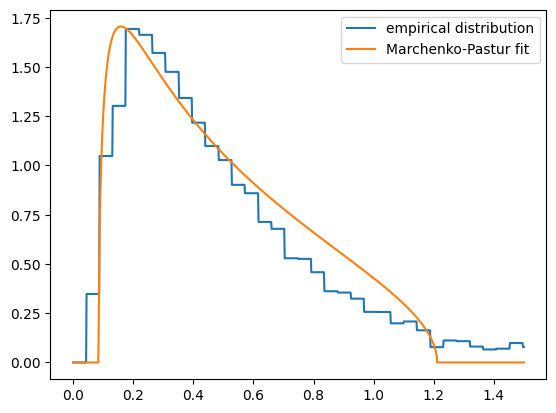

In [20]:
param=find_param(flattened_list_eg,1000)
r = rv_histogram(np.histogram(flattened_list_eg, bins=1000))
z=np.linspace(0,1.5,1000)
y1=r.pdf(z)
vec_Mch=np.vectorize(Mch_pastur)
y2=vec_Mch(z,param[0],param[1])
plt.plot(z,y1,label="empirical distribution")
plt.plot(z,y2,label="Marchenko-Pastur fit")
plt.legend(loc="upper right")
plt.show()

As expected, we obtain a pretty good fit!

We can now clean the correlation matrixes, starting by specifying the treshold $\lambda_+$

In [21]:
##### We can now clean the correlation matrices, starting by specifying the treshold
param=find_param(flattened_list_eg,1000)
treshold=param[0]**2*(1+np.sqrt(param[1]))**2
treshold

1.2112656064735723

In [22]:
#####All eigenvalues below 1.21 are replaced by the average (to preserve the trace)
def clip(mat,treshold):

    if not np.isnan(mat).any():
        egval, egvec = np.linalg.eig(mat)
        idx = np.argsort(egval)
        egval = egval[idx]
        egvec = egvec[:,idx]
        indice=np.searchsorted(egval, treshold, side='left', sorter=None)
        clipped_val=np.mean(egval[0:indice])

        egval[0:indice]=clipped_val
        A=np.diag(egval)
        return np.matmul(np.matmul(egvec,A),np.transpose(egvec))
    else:
        return mat

def extract(df,ind):
    return df.loc[ind].to_numpy()

#function that takes in entry the data frame of all correlation matrixes (rolling_corr) and clean them with clip
#return data frame with cleaned daily correlations matrices
def clean(rolling_corr,treshold):
    rolling_corr_cleaned=rolling_corr.copy(deep=True)
    for index in futures_data.index:
        mat=extract(rolling_corr,index)
        mat=clip(mat,treshold)
        rolling_corr_cleaned.loc[index]=mat
    return rolling_corr_cleaned

Now, we can construct the portfolio that theoretically maximizes the expected gain (under constraint on the variance). Mathematically, this correspond to the optimization problem:

$max\left( \mu^Tw-\frac{\lambda}{2}w^T\Omega w\right)$, where $\mu$ is the expectation of the returns, $\Omega$ the covariance matrix, $w$ the vector of each asset's weight and $\lambda$ and adjustable parameter (risk aversion). The solution is proportional to 
$\Omega^{-1}\mu$

We estimate $\mu$ by computing the rolling average over a one year timescale. Then the daily P&L of the portfolio is computed and standardized. We test its statistical significance and compare the portfolio performance to a benchmark portfolio with constant and equal weights

In [24]:
#unconstrained Markowitz portfolio
#predictor s
#vol and correlation vol, corr: covariance matrix \Omega
#w=argmin w^T\Omega w- s^Tw: (w=\Omega^{-1}s)
def portfolioCoef(s, vol, corr):
    #first recover the covariance matrix from vol vector and corr matrix
    Vol=np.diag(vol)
    Cov=np.matmul(np.matmul(Vol,corr),Vol)
    #compute the Markowitz portfolio
    return np.matmul(np.linalg.inv(Cov),s)

#Computation of the portfolio for each day
#entry: signal, rolling_vol, rolling_corr, clipping treshold
def portfolio(signal,rolling_vol,rolling_corr,treshold):
    rolling_corr_cleaned=clean(rolling_corr,treshold)
    ptf=pd.DataFrame(columns=list_tickers)
    for ind in futures_data.index:
        ptf_t=portfolioCoef(signal.loc[ind].to_numpy(),rolling_vol.loc[ind].to_numpy(),rolling_corr_cleaned.loc[ind].to_numpy())
        ptf.loc[ind]=ptf_t.T
    return ptf

#daily P&L of a portfolio determined at a date t and invested at t+1 day
def pnl(ptf,returns):
    ptf_shifted=ptf.shift(2)
    return ptf_shifted.mul(returns).sum(axis=1,min_count=1)

In [25]:
returns=prices_and_volumes.loc[:,(slice(None),"Return")]
####Signal=returns averaged over 1 year
signal=returns.rolling(250).mean()

####We build portfolio without and with cleaning of the correlation matrices
ptf=portfolio(signal,rolling_vol,rolling_corr,0)
pnl_ptf=pnl(ptf,returns)


ptf_cleaned=portfolio(signal,rolling_vol,rolling_corr,1.25)
pnl_ptf_cleaned=pnl(ptf_cleaned,returns)

pnl_ptf=pnl_ptf/np.std(pnl_ptf)
pnl_ptf_cleaned=pnl_ptf_cleaned/np.std(pnl_ptf_cleaned)

#We also create a test portfolio with uniform and constant weights equal to 1 over each asset, the Markowitz portfolio should overperform it
test_ptf=pd.DataFrame(1, index=futures_data.index, columns=list_tickers)
pnl_test=pnl(test_ptf,returns)
pnl_test=pnl_test/np.std(pnl_test)

In [26]:
t_stat, p_val = stats.ttest_1samp(a=pnl_ptf_cleaned.dropna(), popmean = 0)
t_stat

2.9431759175855507

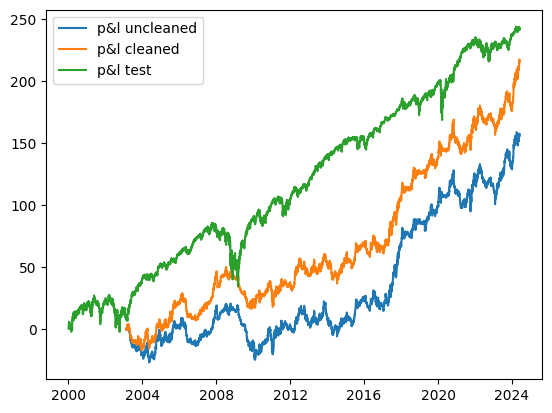

In [27]:
plt.plot(pnl_ptf.cumsum(),label="p&l uncleaned")
plt.plot(pnl_ptf_cleaned.cumsum(), label="p&l cleaned")
plt.plot(pnl_test.cumsum(), label="p&l test")
plt.legend(loc="upper left")
plt.show()

As expected, the result is highly significant, and the portfolio with cleaned correlation matrix perform better than the 'uncleaned portfolio'. However, the naive 'benchmark' portfolio perform better than both. Potential explanations:

-Our asset selection is affected by survivor bias, which might explain why the naive portfolio over perform.

-Our signal predictor is poor.

We will test both these hypothesis in a subsequent project

Next, I explore what happens when transaction costs are taken into account. For now I only include a spread cost, which can be modeled as $spread=|trade|*s$, where $|trade|$ is the absolute value of the trade vector and $s$ is the spread (we take $s=0.0005$%)

In [28]:
######We introduce spread and slippage
#Only spread cost is taken into account for now
def Cost_slippage(gamma,vol,trade,turnover):
    cost=gamma*vol.mul(abs(trade)).mul((abs(trade).div(turnover)).apply(np.sqrt))
    cost = cost.replace([np.inf, -np.inf], 0)
    return cost

def Cost_spread(trade,spread):
    return spread*abs(trade)

def pnl_after_costs(ptf,returns,prices_and_volumes,rolling_vol):
    pnl_before_costs=pnl(ptf,returns)
    volume=prices_and_volumes.loc[:,(slice(None),'Turnover')]
    volume.columns=list_tickers
    trade=(ptf.shift(1)-ptf.shift(2))
    #slip=Cost_slippage(0.3,rolling_vol,trade,volume).sum(axis=1)
    spread=Cost_spread(trade,0.0005).sum(axis=1)
    return(pnl_before_costs-spread)

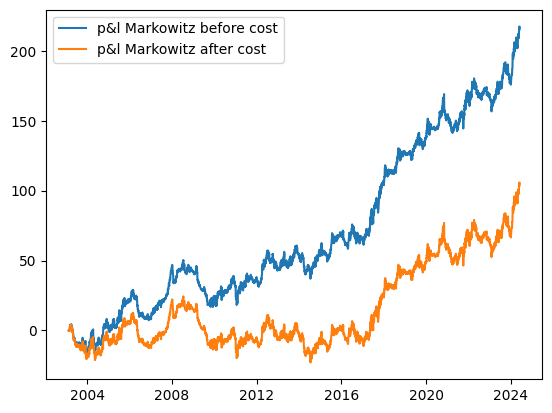

In [29]:
pnl_ptf_after_cost=pnl_after_costs(ptf_cleaned,returns,prices_and_volumes,rolling_vol)
pnl_ptf_after_cost=pnl_ptf_after_cost/np.std(pnl_ptf_after_cost)
plt.plot(pnl_ptf_cleaned.cumsum(),label="p&l Markowitz before cost")
plt.plot(pnl_ptf_after_cost.cumsum(),label="p&l Markowitz after cost")
plt.legend(loc="upper left")
plt.show()

After taking the spread into account, the P&L is significantly reduced

Next, I use the optimization library cvxpy to design an optimised portfolio taking into account the spread cost (which is equivalent to adding a L1 penalization to the Markowitz problem)

In [30]:
def ptf_optimized(gam,signal,rolling_corr,rolling_vol,treshold):
    ptf=pd.DataFrame(0,index=futures_data.index,columns=list_tickers)
    n=len(list_tickers)
    spread_vec=0.0005*np.ones(n)
    rolling_corr_cleaned=clean(rolling_corr,treshold)
    for ind in futures_data.index:
        curr_vol=rolling_vol.loc[ind].to_numpy()
        curr_corr=rolling_corr_cleaned.loc[ind].to_numpy()
        Vol=np.diag(curr_vol)
        Cov=(gam/2)*np.matmul(np.matmul(Vol,curr_corr),Vol)
        curr_signal=signal.loc[ind].to_numpy()

        if not np.isnan(curr_corr).any():
            x=cp.Variable(n)
            prev=ptf.shift(1).loc[ind].to_numpy()
            objective=cp.Minimize(cp.quad_form(x+prev,Cov)+(spread_vec.T @ cp.abs(x))- (curr_signal.T @ (x+prev)))
            prob = cp.Problem(objective)
            prob.solve()
            res=x.value
            ptf.loc[ind]=res.T+prev
    return ptf

In [31]:
gam=1
ptf_opt=ptf_optimized(gam,signal,rolling_corr,rolling_vol,treshold)

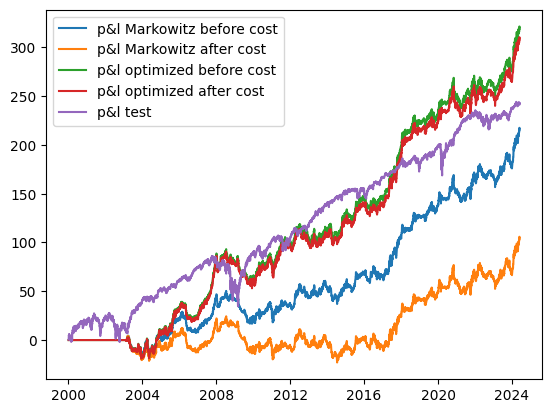

In [32]:
pnl_ptf_opt=pnl(ptf_opt,returns)
pnl_ptf_opt_cost=pnl_after_costs(ptf_opt,returns,prices_and_volumes,rolling_vol)
pnl_ptf_opt=pnl_ptf_opt/np.std(pnl_ptf_opt)
pnl_ptf_opt_cost=pnl_ptf_opt_cost/np.std(pnl_ptf_opt_cost)

#pnl of Markowitz portfolio without spread cost
plt.plot(pnl_ptf_cleaned.cumsum(),label="p&l Markowitz before cost")
#pnl of Markowitz portfolio taking into account spread cost
plt.plot(pnl_ptf_after_cost.cumsum(),label="p&l Markowitz after cost")
#pnl of optimized portfolio without spread cost
plt.plot(pnl_ptf_opt.cumsum(),label="p&l optimized before cost")
#pnl of optimized portfolio taking into account spread costs
plt.plot(pnl_ptf_opt_cost.cumsum(),label="p&l optimized after cost")
plt.plot(pnl_test.cumsum(),label="p&l test")
plt.legend(loc="upper left")
plt.show()

The optimized portfolio overperform all the previously constructed portfolios in terms of P&L